# 📈 NeuralProphet: Hybryda Klasyki i Deep Learningu

Większość sieci neuronowych to "wszystko albo nic" (wrzucasz dane, wypluwasz wynik).
Modele typu Prophet (Additive Models) działają jak klocki:
1.  **Klocek Trendu:** Odpowiada za wzrost/spadek.
2.  **Klocek Sezonowości:** Odpowiada za cykle (używa szeregów Fouriera).
3.  **Klocek AR (Auto-Regresji):** Odpowiada za krótkotrwałe zależności (np. wczorajsza cena wpływa na dzisiejszą).

W PyTorch możemy to zaimplementować jako **osobne warstwy `nn.Module`**, których wyniki po prostu **dodajemy** do siebie na końcu.

$$ \hat{y} = T(t) + S(t) + AR(x) $$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_SAMPLES = 1000

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Generowanie Danych (Trend + Sezon)

Stworzymy dane, które mają wyraźne składniki, żeby sprawdzić, czy nasza sieć potrafi je potem rozdzielić.

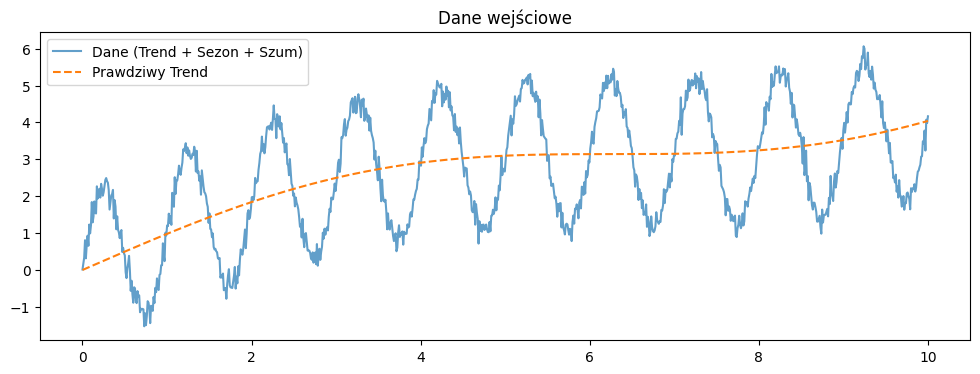

In [2]:
# Czas (znormalizowany 0-1)
t = np.linspace(0, 10, N_SAMPLES)
time_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1).to(DEVICE)

# 1. Trend (Liniowy + lekkie zagięcie)
trend = 0.5 * t + np.sin(t * 0.5)

# 2. Sezonowość (Szybka sinusoida)
seasonality = 2.0 * np.sin(2 * np.pi * t) # Okres = 1

# Suma + Szum
y_true = trend + seasonality + np.random.normal(0, 0.2, N_SAMPLES)
y_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1).to(DEVICE)

plt.figure(figsize=(12, 4))
plt.plot(t, y_true, label='Dane (Trend + Sezon + Szum)', alpha=0.7)
plt.plot(t, trend, label='Prawdziwy Trend', linestyle='--')
plt.title("Dane wejściowe")
plt.legend()
plt.show()

## Moduł 1: Sezonowość (Fourier Layer)

Jak nauczyć sieć pór roku?
Używamy **Szeregu Fouriera**.
Zamiast uczyć się "kształtu fali" punkt po punkcie, uczymy się **współczynników** dla sinusów i cosinusów o różnych częstotliwościach.

$$ S(t) = \sum_{n=1}^{N} [a_n \cos(2\pi n t) + b_n \sin(2\pi n t)] $$

Sieć uczy się parametrów $a_n$ i $b_n$.

In [3]:
class FourierSeasonality(nn.Module):
    def __init__(self, n_orders=5):
        super().__init__()
        self.n_orders = n_orders
        # Uczymy się wag dla sin i cos (2 * n_orders parametrów)
        self.weights = nn.Linear(2 * n_orders, 1, bias=False)

    def forward(self, t):
        # t: [Batch, 1]
        # Generujemy cechy Fouriera: [sin(2pi*1*t), cos(2pi*1*t), sin(2pi*2*t)...]
        features = []
        for i in range(1, self.n_orders + 1):
            features.append(torch.sin(2 * np.pi * i * t))
            features.append(torch.cos(2 * np.pi * i * t))
            
        features = torch.cat(features, dim=1) # [Batch, 2*N]
        
        # Mnożymy przez wyuczone wagi
        return self.weights(features)

# Test
fourier = FourierSeasonality(n_orders=3).to(DEVICE)
out = fourier(time_tensor[:5])
print(f"Fourier output shape: {out.shape}")

Fourier output shape: torch.Size([5, 1])


## Moduł 2: Trend (Piecewise Linear / MLP)

W oryginalnym Prophecie trend to "łamana" (Piecewise Linear).
W NeuralProphet możemy użyć po prostu małej sieci MLP, która nauczy się ogólnego kształtu (Growth).

Dla uproszczenia użyjemy tu prostego MLP z dwiema warstwami.

In [4]:
class TrendModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, t):
        return self.net(t)

## Model Hybrydowy (Składanie Klocków)

Nasz model to po prostu suma wyjść z modułów.
$$ Output = Trend(t) + Seasonality(t) $$

*Uwaga: W pełnym NeuralProphet dochodzi jeszcze moduł AR (AutoRegresja), który patrzy na przeszłe $y$, ale tu skupiamy się na dekompozycji czasu $t$.*

In [5]:
class NeuralProphetLite(nn.Module):
    def __init__(self):
        super().__init__()
        self.trend_block = TrendModule()
        self.season_block = FourierSeasonality(n_orders=5)
        
    def forward(self, t):
        trend = self.trend_block(t)
        season = self.season_block(t)
        return trend + season, trend, season

model = NeuralProphetLite().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

print("Model gotowy.")

Model gotowy.


Epoka 0 | Loss: 12.9519
Epoka 50 | Loss: 1.3254
Epoka 100 | Loss: 0.6423
Epoka 150 | Loss: 0.3394
Epoka 200 | Loss: 0.1809
Epoka 250 | Loss: 0.0970
Epoka 300 | Loss: 0.0624
Epoka 350 | Loss: 0.0491
Epoka 400 | Loss: 0.0442
Epoka 450 | Loss: 0.0424


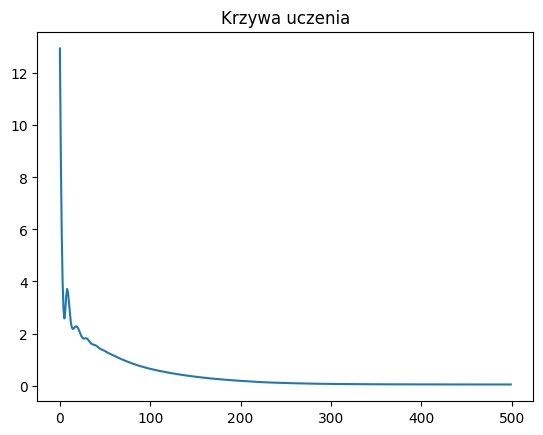

In [6]:
# TRENING
# NeuralProphet uczy się bardzo szybko, bo ma mało parametrów.

epochs = 500
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward (zwraca sumę oraz komponenty osobno)
    y_pred, trend_pred, season_pred = model(time_tensor)
    
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoka {epoch} | Loss: {loss.item():.4f}")

plt.plot(loss_history)
plt.title("Krzywa uczenia")
plt.show()

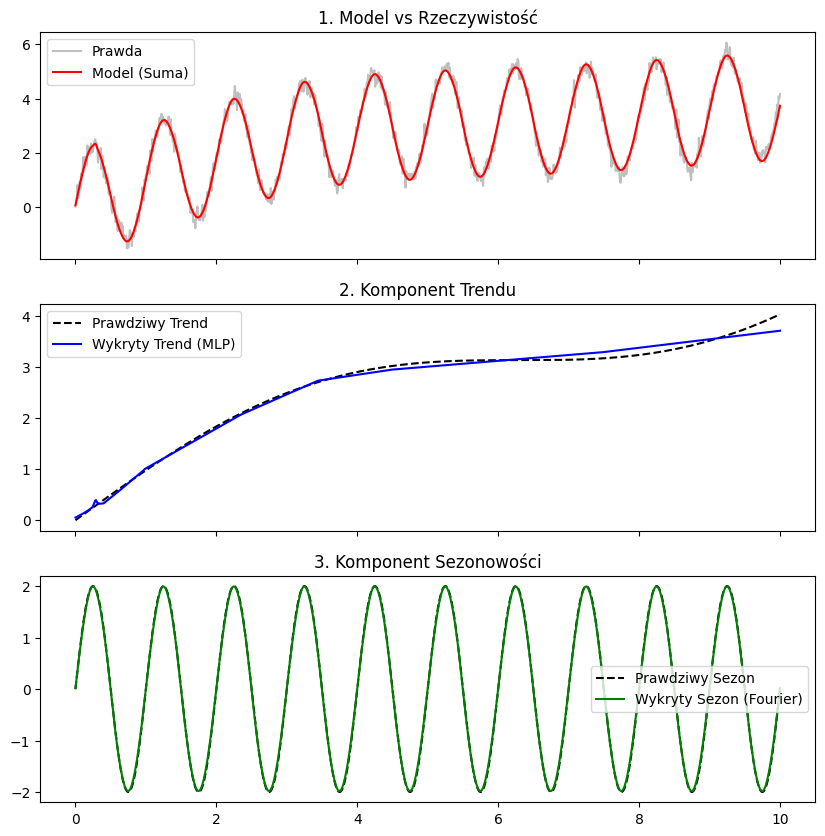

In [7]:
# DEKOMPOZYCJA WIZUALNA (Magia Addytywności)

with torch.no_grad():
    y_pred, trend_pred, season_pred = model(time_tensor)
    
y_pred = y_pred.cpu().numpy()
trend_pred = trend_pred.cpu().numpy()
season_pred = season_pred.cpu().numpy()

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# 1. Całość
ax[0].plot(t, y_true, label='Prawda', color='gray', alpha=0.5)
ax[0].plot(t, y_pred, label='Model (Suma)', color='red')
ax[0].set_title("1. Model vs Rzeczywistość")
ax[0].legend()

# 2. Trend
ax[1].plot(t, trend, label='Prawdziwy Trend', color='black', linestyle='--')
ax[1].plot(t, trend_pred, label='Wykryty Trend (MLP)', color='blue')
ax[1].set_title("2. Komponent Trendu")
ax[1].legend()

# 3. Sezonowość
ax[2].plot(t, seasonality, label='Prawdziwy Sezon', color='black', linestyle='--')
ax[2].plot(t, season_pred, label='Wykryty Sezon (Fourier)', color='green')
ax[2].set_title("3. Komponent Sezonowości")
ax[2].legend()

plt.show()

## 🧠 Podsumowanie: Dlaczego to jest potężne?

Spójrz na wykresy. Sieć neuronowa **sama rozdzieliła** sygnał na dwie części.
*   MLP "zjadł" powolne zmiany (Trend).
*   Warstwa Fouriera "zjadła" szybkie cykle (Sezon).

**Zastosowanie w biznesie:**
Gdy prezes pyta: *"Jaka będzie sprzedaż w grudniu?"*, model odpowiada:
*"Będzie wysoka (1000 sztuk), z czego:*
*   *800 sztuk wynika z tego, że firma rośnie (Trend).*
*   *200 sztuk wynika z tego, że idą Święta (Sezon).*
*   *Gdyby nie święta, sprzedalibyśmy 800."*

Tego wyjaśnienia nie da Ci zwykły LSTM ani Transformer. Dlatego hybrydy (NeuralProphet) są tak popularne w forecastingu.